## **Assignment 5: Evolutionary Algorithms**

**Due: Friday, November 15, 2024**



## **Setup**





**Please log into your Stanford Google Drive account when viewing this notebook.** Log in using your SUNetID credentials.

Before we can start Assignment 5, we need to go through a few minor tasks, as we did in Assignment 1:
1. Copy Google Colab Notebook (File > Save a copy in Drive)
2. Connect to Github Data Repo
3. Set Up Working Directory

The detailed instructions for the above tasks were provided in Assignment 1, so we don't need to go through them again here. If you need assistance with any of the above tasks, please refer to Assignment 1. We'll simply implement tasks 2 and 3 in the code cell below.

In [ ]:
# Connect to Github Data Repo
!git clone https://github.com/verma-aniket/CEE_266G_Data_Repo GitRepo

# Set up working directory
import os
wdir = 'GitRepo/Data'
os.chdir(wdir)

Cloning into 'GitRepo'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 50 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 1.03 MiB | 5.23 MiB/s, done.
Resolving deltas: 100% (10/10), done.


*** Please remember to save a copy of this Google Colab notebook to your drive so that you can edit it.**

Once the above code cell is finished running, you are ready to start Assignment 5!

A special package must be installed before you can work on this assignment. Please run the code cell below to install the package "Platypus".

In [ ]:
# Need to install a special python library
!pip install platypus-opt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 5.5 MB/s eta 0:00:00


## **Assignment 5**

**You are encouraged to discuss the problems with your group and with the teaching team. You may not collaborate with students outside your group.  The final code and write up you submit must be your own.**

This assignment has one problem. In class, we optimized a two-point hedging rule for Folsom reservoir using inflow data on a monthly timestep over the period 2001-2015. The hedging rule is  defined by two values $h_f$ and $h_0$, which are illustrated in the slides from Session 13 and implemented in the simulation model in the code.

The code used in class is included below, adapted for Oroville reservoir.

In the code snippet below, we will import the required libraries for Assignment 5.

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import functools
from platypus.algorithms import NSGAII
from platypus.core import Problem
from platypus.types import Real


The code used in class is below as a starting point.



In [ ]:
# Set some parameters
K = 3537 # capacity, TAF
D = 275 # target yield, TAF
a = 0.35
b = 2.3 # cost function parameters

# data setup
historical_flow = np.loadtxt('ORO-monthly-inflow-TAF.csv', delimiter=',', skiprows=1, usecols=[1])
T = len(historical_flow)

In [ ]:
# same function, but now returns 2 objectives
def simulate(x, streamflow):
  S = np.zeros(T)
  R = np.zeros(T)
  cost = np.zeros(T)
  h0 = x[0]
  hf = x[1]
  Q = streamflow

  S[0] = K # start simulation full
  reliability = 0

  for t in range(1,T):

    # new storage: mass balance, max value is K - this deals with spill
    S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)

    # determine R from hedging policy
    W = S[t] + Q[t]
    if W > hf:
      R[t] = D
      reliability += 1.0/T
    elif W < h0:
      R[t] = W
    else:
      R[t] = (D-h0)/(hf-h0)*(W-h0)+h0

    shortage = D-R[t]
    cost[t] = a*shortage**b

  return [cost.mean(), reliability]

In [ ]:
# Problem(number of decisions, number of objectives)
problem = Problem(2, 2)
problem.types[0] = Real(0,D)  # feasible range of ho
problem.types[1] = Real(D,K+D) # feasible range of hf
problem.directions[1] = Problem.MAXIMIZE # default for 0th is minimize
problem.function = functools.partial(simulate, streamflow=historical_flow)

algorithm = NSGAII(problem)

# optimize the problem using 10000 function evaluations
algorithm.run(10000)

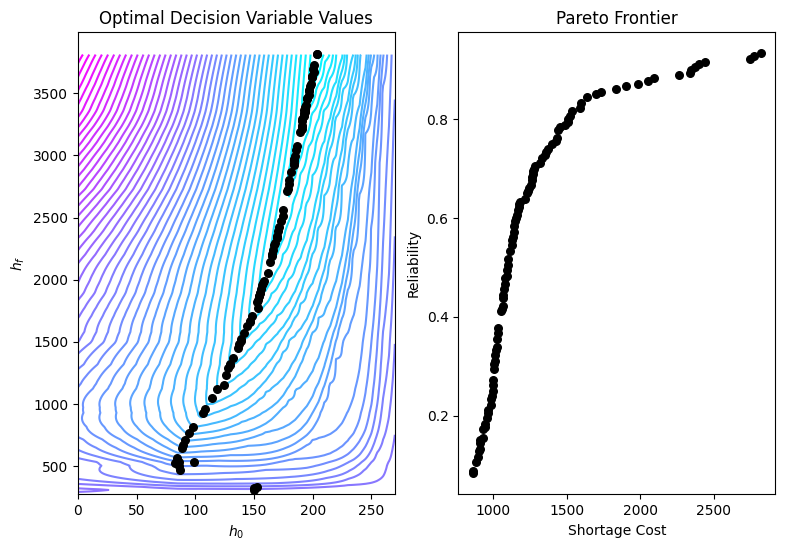

In [ ]:
# Plot results
# convert data to numpy first..
obj = np.array([s.objectives for s in algorithm.result])
x = np.array([s.variables for s in algorithm.result])

# to make a contour plot...
h0s = np.arange(0,D,5)
hfs = np.arange(D,K+D,5)
X,Y = np.meshgrid(h0s, hfs)
costs = np.zeros((len(h0s),len(hfs)))
rels = np.zeros((len(h0s),len(hfs)))
i,j = 0,0

# fill in matrices for contour plot
for i,h0 in enumerate(h0s):
  for j,hf in enumerate(hfs):
    costs[i,j],rels[i,j] = simulate([h0,hf], streamflow=historical_flow)

plt.rcParams['figure.figsize'] = (9, 6) # Make our plots bigger.

plt.subplot(1,2,1)
plt.contour(X,Y,costs.T, 50, cmap=plt.cm.cool)
# plt.contour(X,Y,rels.T, 50, cmap=plt.cm.Reds)
plt.scatter(x[:,0],x[:,1], s=30, color='k', zorder=5)
plt.xlabel(r'$h_0$')
plt.ylabel(r'$h_f$')
plt.title('Optimal Decision Variable Values')

plt.subplot(1,2,2)
plt.scatter(obj[:,0],obj[:,1], s=30, color='k')
plt.xlabel('Shortage Cost')
plt.ylabel('Reliability')
plt.title('Pareto Frontier')

plt.show()

*Part A*: Use this historical inflow data to generate three new streamflow scenarios:


1.   Make a new inflow timeseries called "dry_flow". Create it by multiplying the historical record by 0.8, so that the streamflow has the same historical pattern, but scaled down by 20%.
2.   Make a new inflow timeseries called "wet_flow". Create it by multiplying the historical record by 1.2, so that the streamflow has the same historical pattern, but scaled up by 20%.
3.   Make another new inflow timeseries called "variable_flow". Create it by calculating the daily standardized anomalies from the mean historical flow, multiplying the standardized anomalies by 1.2, and then retransforming the data. The equations below show this procedure, where $x_t$ is the original streamflow in time t, $\bar{x}$ is the mean historical streamflow, $\sigma$ is the standard deviation of historical streamflow, $s_t'$ is the adjusted standardized anomalies, and $x_t'$ is the retransformed data, the "variable_flow". Truncate any negative values to 0.



  $s_t = (x_t - \bar{x})/\sigma$

  $s_t' = [(x_t - \bar{x})/\sigma] * 1.2$

  $x_t' = s_t'*\sigma + \bar{x}$

Plot these new streamflow scenarios and the historical ones in a single plot.

Text(0.5, 1.0, 'Flow Time Series')

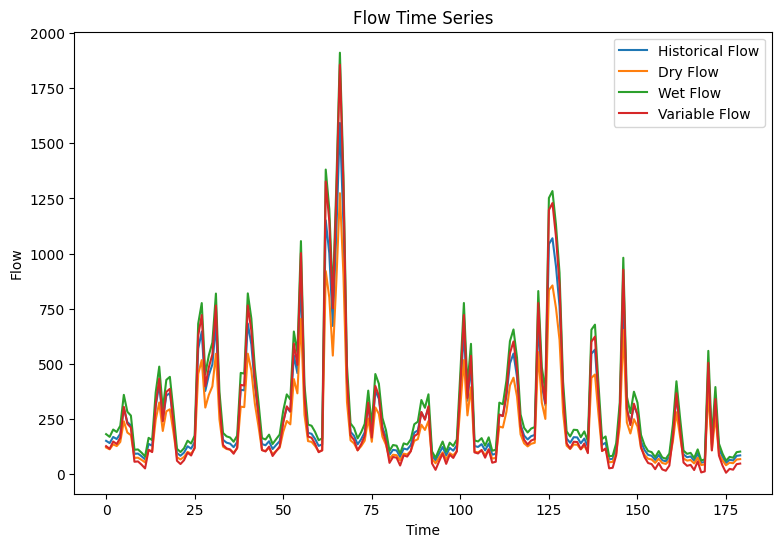

In [ ]:
# Plot streamflow scenarios and historical data
dry_flow = 0.8 * historical_flow
wet_flow = 1.2 * historical_flow

# Variable flow
st = (historical_flow - np.mean(historical_flow))/np.std(historical_flow)
st_n = st * 1.2
variable_flow = st_n * np.std(historical_flow) + np.mean(historical_flow)
variable_flow[variable_flow < 0] = 0

plt.plot(historical_flow, label="Historical Flow")
plt.plot(dry_flow, label="Dry Flow")
plt.plot(wet_flow, label="Wet Flow")
plt.plot(variable_flow, label="Variable Flow")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Flow")
plt.title("Flow Time Series")


*Part B:* For each of the new streamflow scenarios from (a), find a set of Pareto optimal solutions for $h_f$ and $h_0$ that minimize water shortage costs and maximize reliability. Note: this is what the provided code above already does for historical inflow. Make a single plot that has:


*   On the left panel, the values of the decision variables for the Pareto optimal solutions
*   On the right panel, the optimal objective values plotted as a Pareto frontier. Below is a plot of what this looks like.

You need to add 3 additional Pareto frontiers to the same plot, one for each of the new streamflow scenarios.

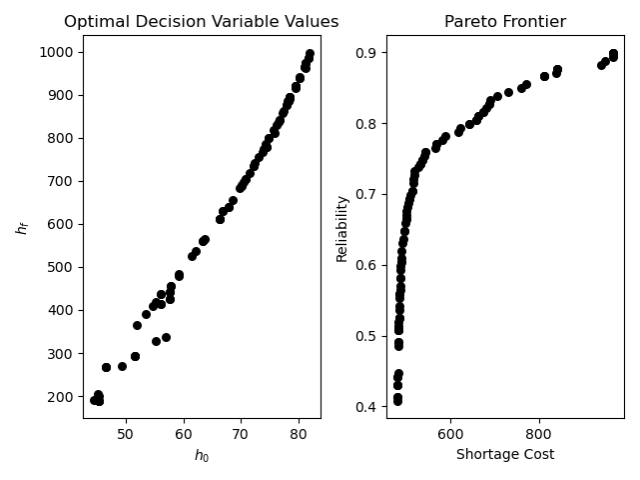

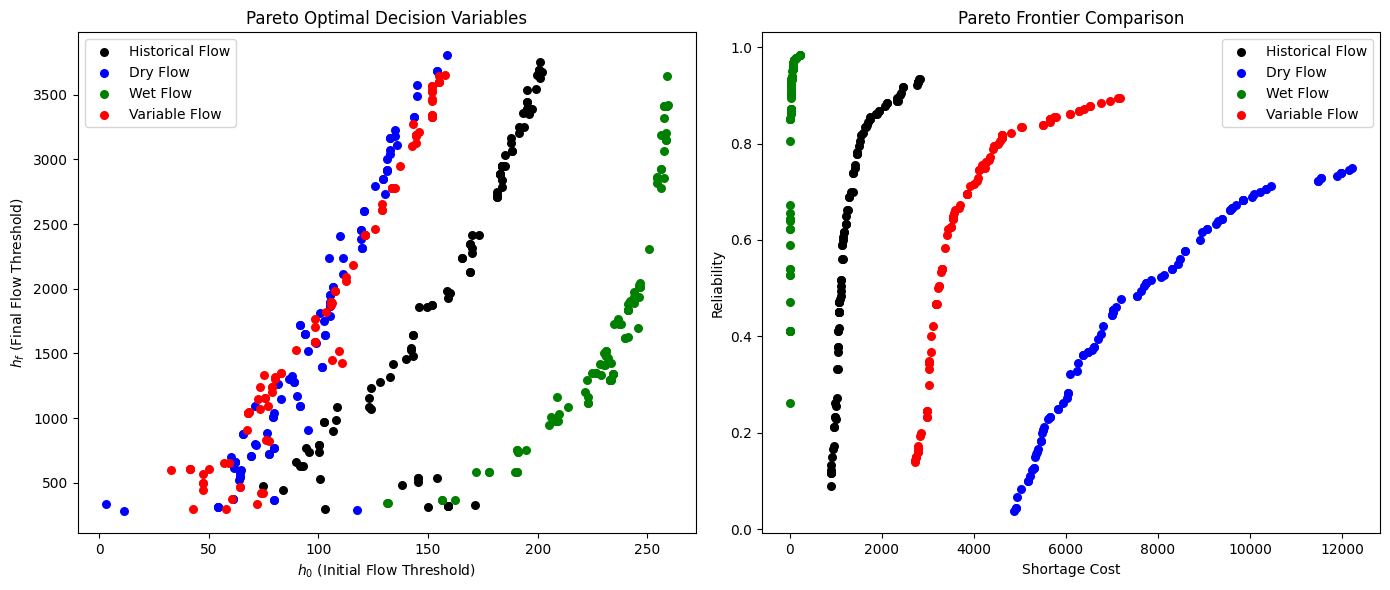

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from platypus import NSGAII, Problem, Real

# Define the flows and scenario names
flows = [historical_flow, dry_flow, wet_flow, variable_flow]
flow_names = ['Historical Flow', 'Dry Flow', 'Wet Flow', 'Variable Flow']
colors = ['k', 'b', 'g', 'r']

# Initialize lists to store results
objs = []
xs = []

# Iterate over flow scenarios
for flow in flows:
    # Define the optimization problem
    problem = Problem(2, 2)
    problem.types[0] = Real(0, D)          # Feasible range of h0
    problem.types[1] = Real(D, K + D)      # Feasible range of hf
    problem.directions[1] = Problem.MAXIMIZE  # Default for the 0th is minimize

    # Fix streamflow for this scenario
    problem.function = functools.partial(simulate, streamflow=flow)

    # Define the optimization algorithm
    algorithm = NSGAII(problem)

    # Run optimization with 1000 function evaluations
    algorithm.run(1000)

    # Extract objectives and decision variables
    obj = np.array([s.objectives for s in algorithm.result])
    x = np.array([s.variables for s in algorithm.result])

    # Store the objectives and decision variables
    objs.append(obj)
    xs.append(x)

# Plotting
plt.figure(figsize=(14, 6))

# Left Panel: Decision Variables
plt.subplot(1, 2, 1)
for i, (x, name, color) in enumerate(zip(xs, flow_names, colors)):
    plt.scatter(x[:, 0], x[:, 1], s=30, label=name, color=color)
plt.xlabel(r'$h_0$')
plt.ylabel(r'$h_f$')
plt.title('Pareto Optimal Decision Variables')
plt.legend()

# Right Panel: Pareto Frontiers
plt.subplot(1, 2, 2)
for i, (obj, name, color) in enumerate(zip(objs, flow_names, colors)):
    plt.scatter(obj[:, 0], obj[:, 1], s=30, label=name, color=color)
plt.xlabel('Shortage Cost')
plt.ylabel('Reliability')
plt.title('Pareto Frontier Comparison')
plt.legend()

plt.tight_layout()
plt.show()


*Part C:* In the plot from part (b), how do the Pareto frontiers compare across the streamflow scenarios and why?

**Historical flow:** baseline.

**Dry flow:** Pareto frontier shifts upward and to the right compared to the historical flow sicne higher shortage costs and potentially lower reliability are expected due to reduced water availability in the system.

**Wet flow:** Pareto frontier shifts downward and to the left compared to the historical flow becasude lower shortage costs and higher reliability are expected due to increased water availability.

**Varibale flow:** Pareto frontier shifts upward and to the right compared to the historical flow but not as much as the dry scenario. This scenario Variability in inflows leads to higher costs than historical flow, even at similar reliability levels.

*Part D:* In the plot from part (b), how do the decision variable optimal values (i.e. $h_f$ and $h_0$) compare across the streamflow scenarios and why?

**Historical flow:** baseline.

**Dry flow:** Decision variables are clustered at lower $h_f$ and $h_0$ values. Smaller thresholds are necessary to conserve water, reflecting limited inflow availability in a dry scenario.

**Wet flow:** Decision variables are spread to higher $h_f$ and $h_0$ values. Higher thresholds are feasible and optimal because surplus water allows for greater flexibility in management.

**Varibale flow:** Decision variables are more scattered (similar to dry flow scenario) which reflects the need to manage the extremes of variability in inflows, where both dry and wet conditions must be accounted for.

*Part E:*  The solution [$h_0 = 114.83, h_f = 1054.46$] is on the Pareto frontier for the historical streamflow, as seen in the plot from part (b). Simulate this policy in all four streamflow scenarios and report both the shortage cost and reliability objective values. How does the policy perform differently in the alternative streamflow scenarios and why?

In [ ]:
# Simulate the policy under all four streamflow scenarios
flows = [historical_flow, dry_flow, wet_flow, variable_flow]
flow_names = ['Historical Flow', 'Dry Flow', 'Wet Flow', 'Variable Flow']

costs = []
rels = []

for i in range(len(flows)):

    cost, rel = simulate([114.83, 1054.46], streamflow=flows[i])

    costs.append(cost)
    rels.append(rel)

    print(f"{flow_names[i]}: Shortage Cost = {cost}, Reliability = {rel}")


Historical Flow: Shortage Cost = 1634.7190721174934, Reliability = 0.8388888888888869
Dry Flow: Shortage Cost = 8543.917804444176, Reliability = 0.5333333333333324
Wet Flow: Shortage Cost = 302.78643275013974, Reliability = 0.9555555555555532
Variable Flow: Shortage Cost = 4864.05390022903, Reliability = 0.7999999999999982


In [ ]:
# Report the shortage costs and reliability objective values

**Historical flow** This is the baseline scenario where the policy was optimized. The performance reflects a good trade-off between cost and reliability, balancing the historical inflows.

**Wet flow** Lowest storage cost and highest reliability. The increased inflow ensures ample water availability, reducing the chance of shortages. Reliability is nearly maximized because the thresholds can be easily met.

**Dry flow** Highest storage cost and lowest reliability. The reduced inflow creates higher water shortages, increasing costs and decreasing reliability. The thresholds may be too high to sustain operations effectively under scarce water availability.

**Varibale flow** The policy performs worse than in the historical flow but better than the dry flow. The variability in inflows creates challenges in maintaining consistent performance. During dry extremes, the policy struggles, but wet extremes help balance the overall performance.



To turn in your assignment:
*   Click the "Share" button in the top right corner of the file. Add the three members of the teaching team as viewers, and uncheck the "Notify People" option. Click Share.

*   Go back to the "Share" button and copy the link to your file. Paste the link in the text box below. This allows the teaching team to access the original code file if needed.
*   Please save your Google Colab notebook as a PDF by following the exporting instructions posted on Canvas. Next, hand in your assignment by uploading your pdf to Gradescope.

And that's the end of Assignment 5!

https://colab.research.google.com/drive/10Ox9Ql5BxJQqxHy5dOBoBl3mCSRN4Pwi?usp=sharing